# Import Necessary Libraries

In [ ]:
# Standard libraries
from typing import Literal
from matplotlib.dates import DateFormatter

# Scientific and data manipulation libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import PowerTransformer, StandardScaler

# PyTorch and related tools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchmetrics import MeanSquaredError

from config import Config

## Suppress Warnings

In [9]:
import warnings
warnings.filterwarnings('ignore')

# Load the Dataset

In [ ]:
data = pd.read_csv(Config.train_data_path)

In [11]:
data.head()

,timestamp,consumption
0,2011-01-01 00:15:00,-0.704319
1,2011-01-01 00:30:00,-0.704319
2,2011-01-01 00:45:00,-0.678983
3,2011-01-01 01:00:00,-0.653647
4,2011-01-01 01:15:00,-0.704319


## Check Data Information

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105215 entries, 0 to 105214
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   timestamp    105215 non-null  object 
 1   consumption  105215 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.6+ MB


## Convert Timestamp to Datetime Objects

In [13]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

## Verify Data Types After Conversion

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105215 entries, 0 to 105214
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   timestamp    105215 non-null  datetime64[ns]
 1   consumption  105215 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.6 MB


## Describe Consumption Data

In [15]:
data['consumption'].describe()

,consumption
count,105215.000000
mean,-0.007469
std,1.056835
min,-1.414483
25%,-0.957931
50%,-0.349363
75%,0.797593
max,3.028924


## Visualize Initial Consumption Distribution

In [16]:
def plot_distribution(column):

    # Set style and context
    sns.set_style("whitegrid")
    sns.set_context("notebook", font_scale=1.2)

    # Create figure and subplots
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    # Get column name for titles
    col_name = column.name if column.name else 'Value'

    # Histogram with KDE
    sns.histplot(column, kde=True, color='royalblue', ax=ax[0],
                 edgecolor='white', linewidth=0.5)
    ax[0].set_title(f'{col_name} Distribution', fontsize=14, pad=15)
    ax[0].set_xlabel(col_name)
    ax[0].set_ylabel('Frequency')
    sns.despine(ax=ax[0])

    # Boxplot
    sns.boxplot(y=column, color='lightseagreen', ax=ax[1],
                flierprops=dict(marker='o', markerfacecolor='crimson',
                               markersize=8, markeredgecolor='none'))
    ax[1].set_title(f'{col_name} Spread', fontsize=14, pad=15)
    ax[1].set_ylabel(col_name)
    sns.despine(ax=ax[1])

    # Probability Plot
    stats.probplot(column, plot=ax[2], dist="norm", rvalue=True)
    ax[2].set_title('Normality Check', fontsize=14, pad=15)
    ax[2].set_xlabel('Theoretical Quantiles')
    ax[2].set_ylabel('Ordered Values')
    sns.despine(ax=ax[2])

    plt.tight_layout()
    plt.show()

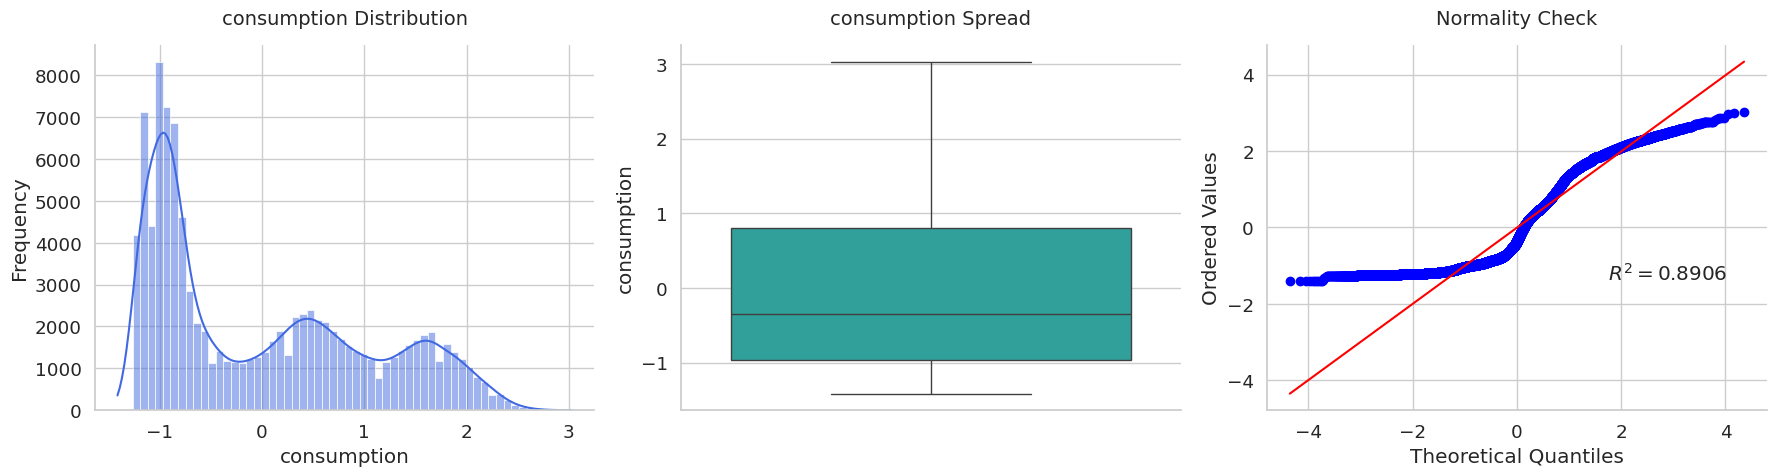

In [17]:
plot_distribution(data['consumption'])

## Apply Yeo-Johnson Power Transformation

This transformation is used to make the data more normally distributed, which can be beneficial for some statistical and machine learning models

In [18]:
# Apply Yeo-Johnson power transformation
pt = PowerTransformer(method='yeo-johnson')
data['consumption'] = pt.fit_transform(data[['consumption']])

## Visualize Consumption Distribution After Yeo-Johnson

assess the effect of the transformation

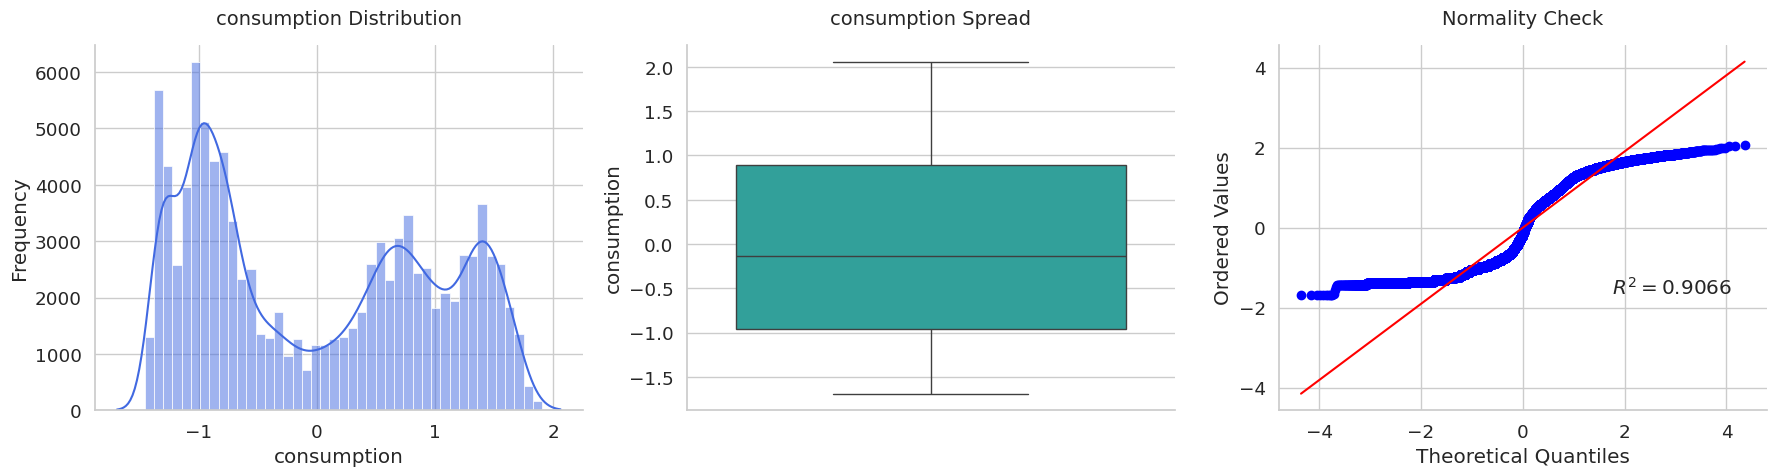

In [19]:
plot_distribution(data['consumption'])

## Apply Standard Scaling and Visualize

apply Standard Scaling to the 'consumption' column, which standardizes the data to have a mean of 0 and a standard deviation of 1. It then visualizes the distribution of the scaled data

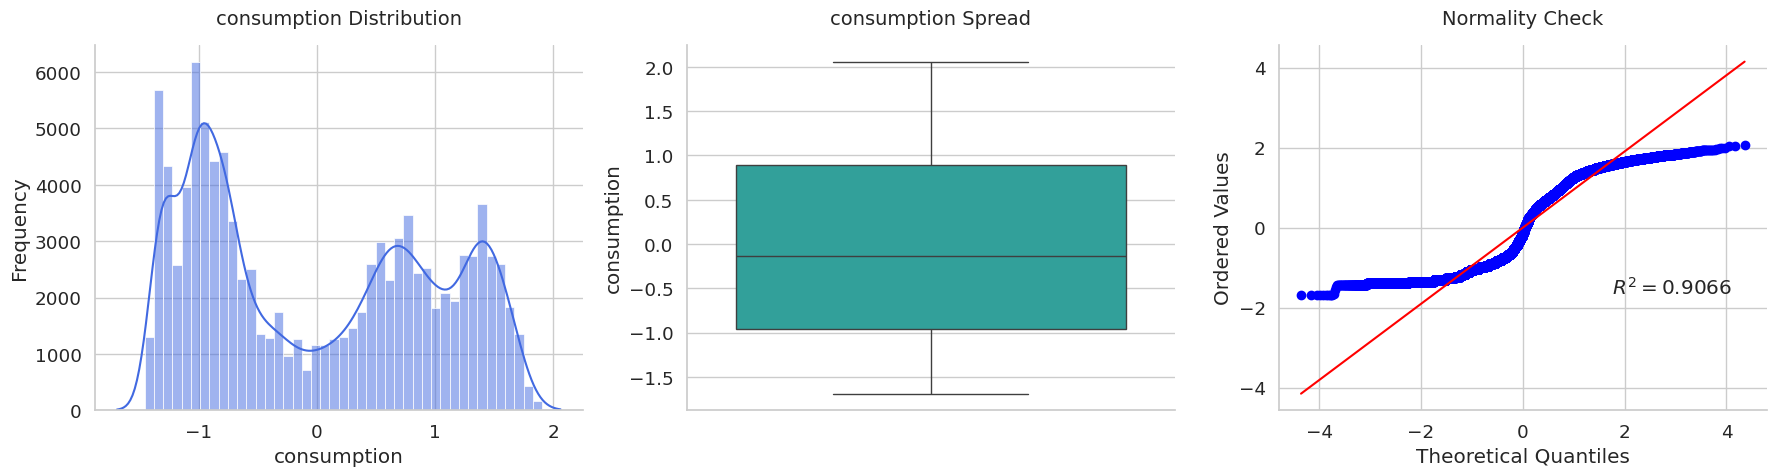

In [20]:
scaler = StandardScaler()
data['consumption'] = scaler.fit_transform(data[['consumption']])
plot_distribution(data['consumption'])

## Save StandardScaler

In [ ]:
import pickle
with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

## Analyze and Visualize Daily and Rolling Consumption Trends

set the 'timestamp' column as the DataFrame index, resample the data to a daily frequency, and calculate a 30-day rolling mean to visualize the overall trend and daily fluctuations in energy consumption over the years.

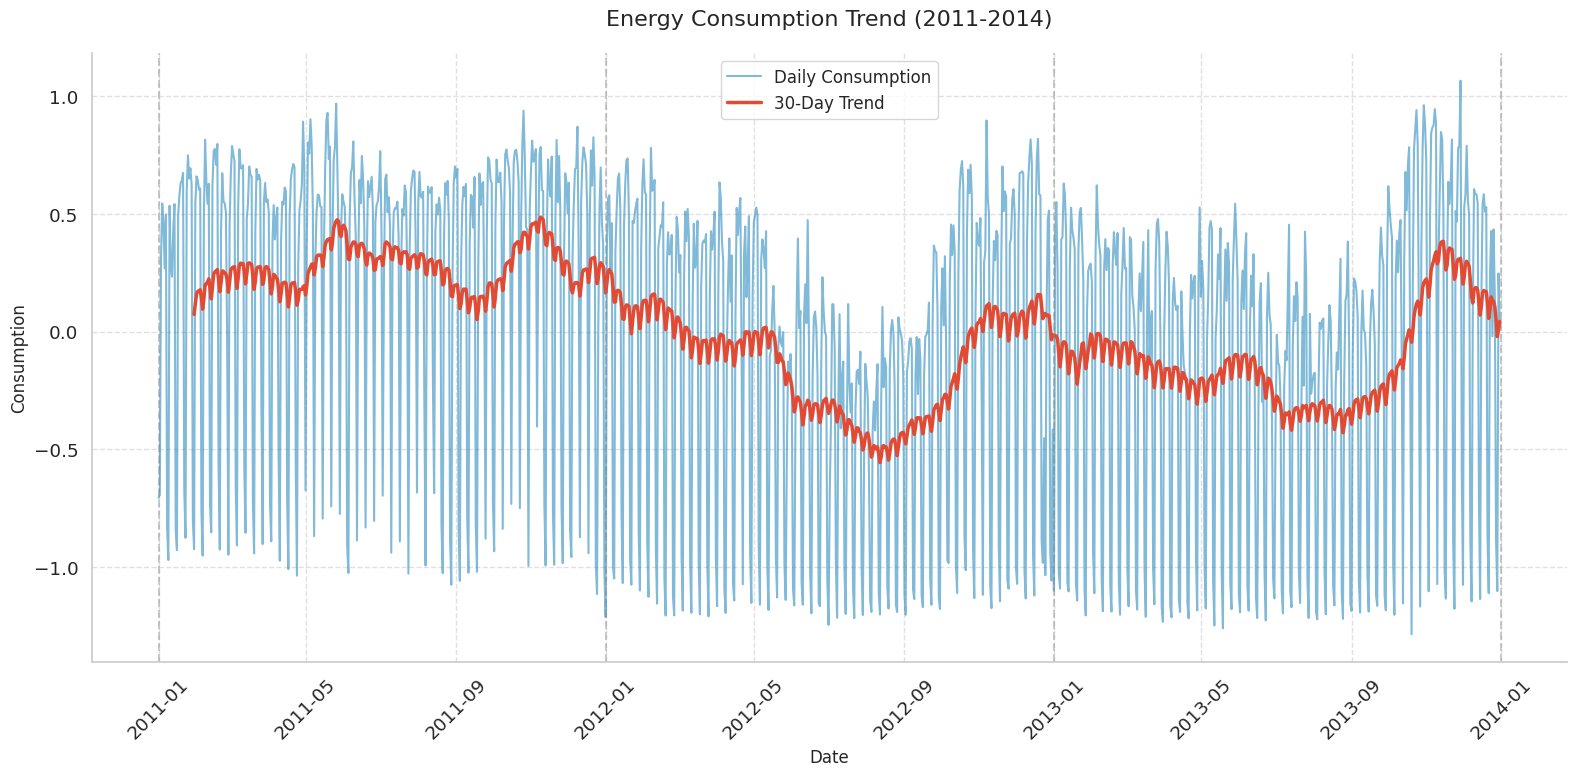

In [22]:
data.set_index('timestamp', inplace=True)

daily = data.resample('D').mean()

sns.set_style("whitegrid")
plt.figure(figsize=(16, 8))

ax = sns.lineplot(
    data=daily,
    x=daily.index,
    y='consumption',
    color='#2b8cbe',
    linewidth=1.5,
    alpha=0.6,
    label='Daily Consumption'
)

rolling = daily.rolling(30).mean()
sns.lineplot(
    data=rolling,
    x=rolling.index,
    y='consumption',
    color='#e34a33',
    linewidth=2.5,
    label='30-Day Trend'
)

ax.set_title('Energy Consumption Trend (2011-2014)', fontsize=16, pad=20)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Consumption', fontsize=12)
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

for year in range(2011, 2015):
    plt.axvline(pd.to_datetime(f'{year}-01-01'), color='gray', linestyle='--', alpha=0.4)

plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
sns.despine()

plt.tight_layout()
plt.show()

# Prepare the data for modeling

## Split Data into Training and Testing Sets

In [23]:
split_idx = int(len(data) * 0.8)
train_data = data.iloc[:split_idx]
test_data = data.iloc[split_idx:]

## Define Sequence Creation Function

define a function `create_sequences` that prepares the time series data for the RNN model. It creates sequences of a specified length (`seq_length`) from the input data, where each sequence is a set of past time steps used to predict the next time step

In [24]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length), 0]
        y = data.iloc[i + seq_length, 0]
        xs.append(x)
        ys.append(y)
    df = pd.DataFrame({'xs': xs, 'ys': ys})
    df.to_csv('sequences.csv', index=False)
    return np.array(xs), np.array(ys)

## Create Training and Testing Sequences

In [25]:
SEQ_LENGTH = 96  # last 24 hours (15-min intervals)

X_train, y_train = create_sequences(train_data, SEQ_LENGTH)
X_test, y_test = create_sequences(test_data, SEQ_LENGTH)

## Create PyTorch Tensor Datasets

In [26]:
dataset_train = TensorDataset(
    torch.from_numpy(X_train).float(),
    torch.from_numpy(y_train).float()
)
dataset_test = TensorDataset(
    torch.from_numpy(X_test).float(),
    torch.from_numpy(y_test).float()
)

## Create PyTorch DataLoaders

In [27]:
dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=False)

# Define Time Series RNN Model and Helper Functions

define the `TimeSeriesRNN` class, a PyTorch module for time series forecasting. It includes support for RNN, GRU, and LSTM layers. It also defines helper functions for training (`train_model`), evaluating (`evaluate_model`), visualizing training history (`plot_training_history`), and plotting predictions against actual values (`plot_predictions`)

In [28]:
class TimeSeriesRNN(nn.Module):
    """RNN model for time series forecasting"""
    def __init__(self, rnn_type: Literal["RNN", "GRU", "LSTM"] = "GRU"):
        super().__init__()
        self.rnn_type = rnn_type

        # RNN layer selection
        rnn_constructors = {
            "RNN": nn.RNN,
            "GRU": nn.GRU,
            "LSTM": nn.LSTM
        }
        self.rnn = rnn_constructors[rnn_type](
            input_size=1,
            hidden_size=32,
            num_layers=2,
            batch_first=True
        )
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        batch_size = x.size(0)
        device = x.device

        # Initialize hidden state
        h0 = torch.zeros(2, batch_size, 32).to(device)
        if self.rnn_type == "LSTM":
            c0 = torch.zeros(2, batch_size, 32).to(device)
            out, _ = self.rnn(x, (h0, c0))
        else:
            out, _ = self.rnn(x, h0)

        return self.fc(out[:, -1, :]).squeeze()

def train_model(model, train_loader, criterion, optimizer, epochs, seq_length):
    """Training loop with progress tracking"""
    history = {
        'train_loss': [],
        'val_loss': [],
        'learning_rate': []
    }

    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_loss = 0.0

        for seqs, labels in train_loader:
            seqs = seqs.view(-1, seq_length, 1)
            optimizer.zero_grad()
            outputs = model(seqs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        history['train_loss'].append(avg_loss)

        # Print progress
        lr = optimizer.param_groups[0]['lr']
        history['learning_rate'].append(lr)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | LR: {lr:.6f}")

    return history

def evaluate_model(model, test_loader, seq_length):
    """Model evaluation"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for seqs, labels in test_loader:
            seqs = seqs.view(-1, seq_length, 1)
            outputs = model(seqs)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

def plot_training_history(history):
    """Visualize training metrics"""
    plt.figure(figsize=(15, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    if 'val_loss' in history:
        plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)

    # Learning rate plot
    plt.subplot(1, 2, 2)
    plt.plot(history['learning_rate'], color='green')
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_predictions(preds, labels, num_samples=200):
    """Visualize predictions vs actual"""
    plt.figure(figsize=(12, 6))

    # Plot first n samples
    plt.plot(labels[:num_samples], label="Actual", alpha=0.7, linewidth=2)
    plt.plot(preds[:num_samples], label="Predicted", linestyle='--', linewidth=1.5)

    plt.title("Predictions vs Actual Values")
    plt.xlabel("Time Steps")
    plt.ylabel("Normalized Consumption")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

## Initialize, Train, and Evaluate the GRU Model

In [29]:
EPOCHS = 10
# Initialize components
model = TimeSeriesRNN(rnn_type="GRU")
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
mse_metric = MeanSquaredError()

    # Train the model
history = train_model(
        model=model,
        train_loader=dataloader_train,
        criterion=criterion,
        optimizer=optimizer,
        epochs=EPOCHS,
        seq_length=SEQ_LENGTH
    )

    # Evaluate
predictions, actuals = evaluate_model(
        model=model,
        test_loader=dataloader_test,
        seq_length=SEQ_LENGTH
    )

test_mse = mse_metric(torch.tensor(predictions), torch.tensor(actuals))
print(f"\nTest MSE: {test_mse:.4f}")

Epoch 1/10 | Loss: 0.0733 | LR: 0.001000
Epoch 2/10 | Loss: 0.0403 | LR: 0.001000
Epoch 3/10 | Loss: 0.0358 | LR: 0.001000
Epoch 4/10 | Loss: 0.0327 | LR: 0.001000
Epoch 5/10 | Loss: 0.0317 | LR: 0.001000
Epoch 6/10 | Loss: 0.0308 | LR: 0.001000
Epoch 7/10 | Loss: 0.0300 | LR: 0.001000
Epoch 8/10 | Loss: 0.0293 | LR: 0.001000
Epoch 9/10 | Loss: 0.0287 | LR: 0.001000
Epoch 10/10 | Loss: 0.0275 | LR: 0.001000

Test MSE: 0.0598


## Visualize Training History and Predictions

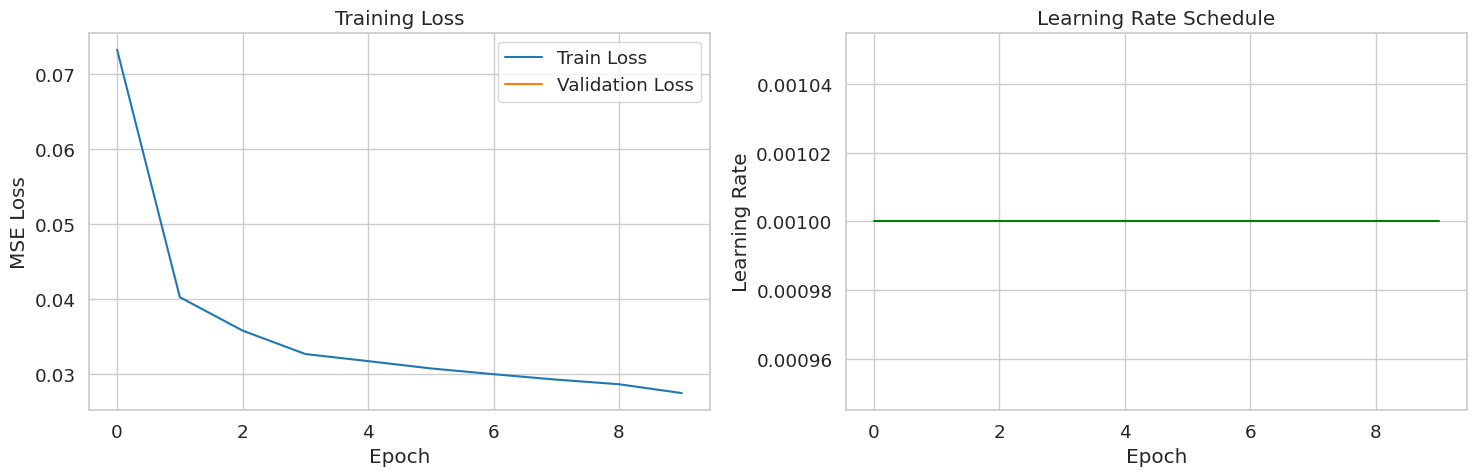

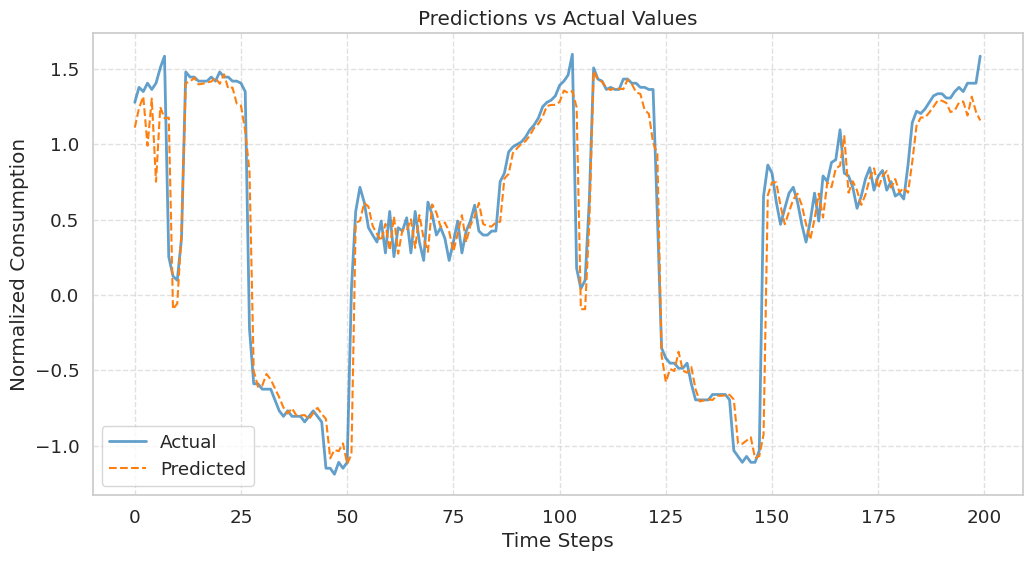

In [30]:
plot_training_history(history)
plot_predictions(predictions, actuals)

In [ ]:
torch.save(model.state_dict(), 'models/TimeSeriesRnn.pth')